# Lower bound of $\tilde\vartheta^d(G, w)$

## Method 1: seesaw algorithm based on quadratic programming

$\tilde\vartheta^d(G, w)$ is defined as

(Eq. 1)
$$\begin{align}
\max_{X}\quad & \sum_{i=1}^n w_i X_{ii}\\
\mathrm{s.t.}\quad & X_{00} = 1, ~ X_{0i} = X_{ii},\\
& X_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E,\\
& X \ge 0, ~ \mathrm{rank}(X) = d.
\end{align}
$$

This is equivalent to the following optimization in the limit $\eta\to+\infty$

(Eq. 2)
$$\begin{align}
\max_{X, Y}\quad & \sum_{i=1}^n w_i X_{ii} - \eta \|X - Y\|_F^2\\
\mathrm{s.t.}\quad & X_{00} = 1, ~ X_{0i} = X_{ii},\\
& X_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E,\\
& Y \ge 0, ~ \mathrm{rank}(Y) = d.
\end{align}
$$

This can be solved by alternatingly performing the following two optimization problems

(Eq. 3)
$$\begin{align}
\max_{X}\quad & \sum_{i=1}^n w_i X_{ii} - \eta \|X - Y_\star\|_F^2\\
\mathrm{s.t.}\quad & X_{00} = 1, ~ X_{0i} = X_{ii},\\
& X_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E.\\
\end{align}
$$

(Eq. 4)
$$\begin{align}
\max_{Y}\quad & \sum_{i=1}^n w_i X_{\star ii} - \eta \|X_\star - Y\|_F^2\\
\mathrm{s.t.}\quad & Y\ge 0, ~ \mathrm{rank}(Y) = d.
\end{align}
$$

In [1]:
import numpy as np
import cvxpy as cvx
import networkx as nx
import scipy.linalg as lin
from scipy.stats import unitary_group, ortho_group

w = [1. 1. 1. 1. 1. 1. 1. 1. 1.]


/tmp/ipykernel_19760/1532849509.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  G = nx.adjacency_matrix(graph, dtype=float).todense()


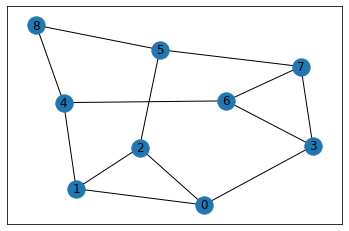

In [2]:
# Define the graph (in graph6 format)
graph = nx.from_graph6_bytes(b'H{O_okK')

# draw the graph
nx.draw_networkx(graph)


# G is the adjacency matrix
G = nx.adjacency_matrix(graph, dtype=float).todense()
#print("The adjacency matrix:\n", G)


# n is the number of vertices
n = G.shape[0]
#print("Number of vertices:", n)

# w_i
w = np.ones(n)

print("w =", w)

In [3]:
# edge indexing
GE = np.zeros((n+1, n+1))
GE[1:, 1:] = G
GE = GE.astype(bool)

# diag indexing without (0, 0)
GD = np.identity(n+1).astype(bool)
GD[0, 0] = False

In [4]:
# the objective function

def obj(X, Y, eta):
    return np.abs(w @ np.diag(X)[1:]) - eta * lin.norm(X - Y)**2

In [5]:
# Explicit solution to (Eq. 3)
# eta=np.inf is used for \min_{X, Y} ||X - Y||_F

def altQP(Y, eta=np.inf):

    Y[GE] = 0
    
    Y[GD] = (4 * Y[0, 1:].real + 2 * Y[GD] + w/eta) / 6
    Y[0, 0] = 1
    Y[0, 1:] = Y[GD]
    Y[1:, 0] = Y[GD]
    
    return Y

In [6]:
# Explicit solution to (Eq. 4)

def altRank(X):
    v, U = lin.eigh(X)
    v[v < 0] = 0
    v[0:n-d+1] = 0
        
    return U @ np.diag(v) @ U.conj().T

In [7]:
# Implement the seesaw algorithm

# dimention to test
d = 3

# number of different initial values to try
num = 10

# eta
eta = 10

# tolerance
tol = 1e-12


for i in range(num):


    U = unitary_group.rvs(n+1)
    D = np.zeros(n+1)
    D[n-d+1:] = np.random.rand(d)
    Y = U @ np.diag(np.abs(D)) @ U.conj().T

    # perform the optimization in (Eq. 2)

    val = - np.inf
    err = np.inf

    while err > tol:

        X = altQP(Y, eta)
        Y = altRank(X)

        err = obj(X, Y, eta) - val
        val = obj(X, Y, eta)

    #print(obj(X, Y, eta), lin.norm(X-Y), err)

    # perform the optimization \min_{X, Y}||X - Y||_F

    diff = - np.inf
    err = np.inf

    while np.abs(err) > tol:

        X = altQP(Y)
        Y = altRank(X)

        err = lin.norm(X-Y) - diff
        diff = lin.norm(X-Y)

    print("max =", np.abs(w @ np.diag(X)[1:]), "\t|| X - Y || =", diff)
    #print(err)

max = 3.3380087899627715 	|| X - Y || = 3.544643586589115e-11
max = 3.2335997994485695 	|| X - Y || = 2.9917826946200856e-11
max = 3.2335997950281556 	|| X - Y || = 2.991506842769711e-11
max = 3.3176645414390316 	|| X - Y || = 2.7417273579040274e-11
max = 3.338008769078763 	|| X - Y || = 3.544813867073406e-11
max = 3.235312003315201 	|| X - Y || = 3.328501709486455e-11
max = 3.3380087910184053 	|| X - Y || = 3.5451183088609186e-11
max = 2.9999298482559027 	|| X - Y || = 3.7068177468810385e-11
max = 2.9999311635792734 	|| X - Y || = 3.700983798900043e-11
max = 3.235311989302322 	|| X - Y || = 3.328445211671245e-11
